In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('news_dataset.csv')
df.shape

(115233, 4)

In [3]:
df.label.value_counts()

economics        9308
tech             9293
business         9258
finance          9167
beauty           9130
entertainment    9028
food             8876
sports           8876
politics         8719
science          8582
travel           8107
world            6211
health           5557
environment      5121
Name: label, dtype: int64

In [4]:
def check_for_noise(df):
    # create a copy
    df = df.copy()
    df = df.fillna(value='', axis=0)
    # create a set for adding all the useless symbols(noise) 
    symbol = set()
    # parse through the data to extract all the unnecessary symbols.
    for col in list(df.columns):
        ### The regular expression states to find all the letters other than words and spaces.
        noise = df[col].str.findall(r'([^\w\s\d]+)')
        for val in noise:
            for sy in val:
                symbol.add(sy)
    # convert back to list.
    symbol = list(symbol)
    return symbol


noises = check_for_noise(df)
print(len(noises))
print(noises[:100])


2361
['"].', 'ैं।', '🐋😱', "),'", '‑', '🎥', "***':", '[]', '）。', 'ा,', '****"', '+?', '-.', ',*', 'ै।…', ')/', '=""', '=', '″', '***.', '){', '?"—', "]'.", '{{^', '.🌊🌊@', 'ँ', '*/', ']),', ',"…', '.***', "'-", ':™', '★★★', '///////////////', '🇧🇾', '🌳', '°', "'…", '\u200b@', '??.', '…….', '%–', '✨✨#', '\u200c,', '️', '#:', 'ी…', '👀🙌🎶', '.%', '.©', ':[', "'?:", '!":', '¦', "?';", '.;;', '💄', "!!,'", '∓', ".)'", '!!!!"', '(₹)', '%)…', '([', '🔵—', '(%', '¿¿¿', '?:@', "'®", '.))', '/@', 'ূ', '🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥', '(/', "('[", ".'[", '😂😂', '😎😎😎😎😎😎', '&;...', "',", '....."', ']**', '🍔', '>:', '!—', '––…', '%,…', '!!"', '∼', '\u200b\u200b(', "!'.", '😍😍😍', '.../', ".':", '+', '™.,', '(…)', "\u200b'", ':--', '\u200b\u200b"']


In [5]:
def preprocess_inputs(df):
    
    # Make a copy of dataset for preprocessing.
    df = df.copy()

    # fill all empty values with blank.
    df = df.fillna(value='', axis=0)

    # remove stopwords from the columns
    f = lambda x: ' '.join([item.lower() for item in x.split(' ') if item.lower() not in stop_words])
    stop_words = set(stopwords.words('english'))
    df['title'] =   df['title'].apply(f)
    df['excerpt'] = df['excerpt'].apply(f)
    df['summary'] = df['summary'].apply(f)

    # clean the data from useless noises
    df['excerpt'] = df['excerpt'].str.replace(r'([^A-Za-z\s]+)', ' ')
    df['summary'] = df['summary'].str.replace(r'([^A-Za-z\s]+)', ' ')
    df['title'] = df['title'].str.replace(r'([^A-Za-z\s]+)', ' ')

    # remove spaces in between
    f = lambda x: ' '.join([item.lower() for item in x.split(' ') if len(item) > 1])
    stop_words = set(stopwords.words('english'))
    df['title'] =   df['title'].apply(f)
    df['excerpt'] = df['excerpt'].apply(f)
    df['summary'] = df['summary'].apply(f)

    
    return df


In [6]:
X = preprocess_inputs(df)

In [7]:
X.head()

,title,excerpt,summary,label
0,veteran broadcaster dave allen joins par mar s...,longtime tri state broadcaster media personali...,press releases posted last hours last days mar...,economics
1,high performance computing center stuttgart ce...,stuttgart germany oct founded germany first na...,stuttgart germany oct founded germany first na...,environment
2,hopes new tech could finally find mh,new technology could finally solve mystery mis...,world biggest aviation mystery experts hope te...,travel
3,married first sight alexis economou looks cosy...,mafs uk star showed toned figure casual black ...,published edt october updated edt october anno...,entertainment
4,syncthink eye tracking vr receives second fda ...,eye sync uses eye tracking evaluate brain func...,eye sync virtual reality system neurotechnolog...,economics


In [13]:
from tqdm import tqdm
from IPython.display import clear_output
import time

for i in tqdm(range(0, 50, 20)):
    arr1 = list(X['title'].iloc[i:i+20])
    arr2 = list(X['label'].iloc[i:i+20])
    for x,y in zip(arr1,arr2):
        print(x," ==== ",y)
    clear_output(wait=True)
    time.sleep(10)


100%|██████████| 3/3 [00:30<00:00, 10.02s/it]


In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report


In [21]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=0):
    sequences = tokenizer.texts_to_sequences(texts)

    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))

    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

    return sequences


In [41]:
def training(df,mapping):
    df = df.copy()
    # Use only the headline and category columns
    df = df.loc[:, ['title', 'label','excerpt']]
    # Split df into X and y
    df['label'] = df['label'].replace(mapping)
    y = df['label']
    X = df['title'] + ' ' +df['excerpt']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, shuffle=True, random_state=1)

    # Fit a tokenizer
    tokenizer = Tokenizer(num_words=30000)
    tokenizer.fit_on_texts(X_train)

    # Get sequence data
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False,
                           max_seq_length=X_train.shape[1])

    return X_train, X_test, y_train, y_test


mapping = {'economics': 0,
           'tech': 1,
           'business': 2,
           'finance': 3,
           'beauty': 4,
           'entertainment': 5,
           'food': 6,
           'sports': 7,
           'politics': 8,
           'environment': 9,
           'science': 10,
           'travel': 11,
           'world': 12,
           'health': 13
           }


X_train, X_test, y_train, y_test = training(X,mapping)


In [42]:
X_train.shape,y_train.shape

((80663, 105), (80663,))

In [43]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

embedding = tf.keras.layers.Embedding(
    input_dim=30000,
    output_dim=64
)(inputs)

flatten = tf.keras.layers.Flatten()(embedding)

dense_1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(14, activation='softmax')(dense_2)


model = tf.keras.Model(inputs, outputs)

print(model.summary())
tf.keras.utils.plot_model(model)


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 105)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 105, 64)           1920000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 6720)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               860288    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 14)                1806      
Total params: 2,798,606
Trainable params: 2,798,606
Non-trainable params: 0
_________________________________________________

In [44]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)


Epoch 1/100
2017/2017 [==============================] - 52s 26ms/step - loss: 1.7085 - accuracy: 0.4697 - val_loss: 1.3957 - val_accuracy: 0.5853
Epoch 2/100
2017/2017 [==============================] - 53s 26ms/step - loss: 0.8894 - accuracy: 0.7306 - val_loss: 1.4729 - val_accuracy: 0.5752
Epoch 3/100
2017/2017 [==============================] - 52s 26ms/step - loss: 0.3037 - accuracy: 0.9128 - val_loss: 2.0848 - val_accuracy: 0.5422
Epoch 4/100
2017/2017 [==============================] - 53s 26ms/step - loss: 0.1187 - accuracy: 0.9712 - val_loss: 2.3834 - val_accuracy: 0.5399


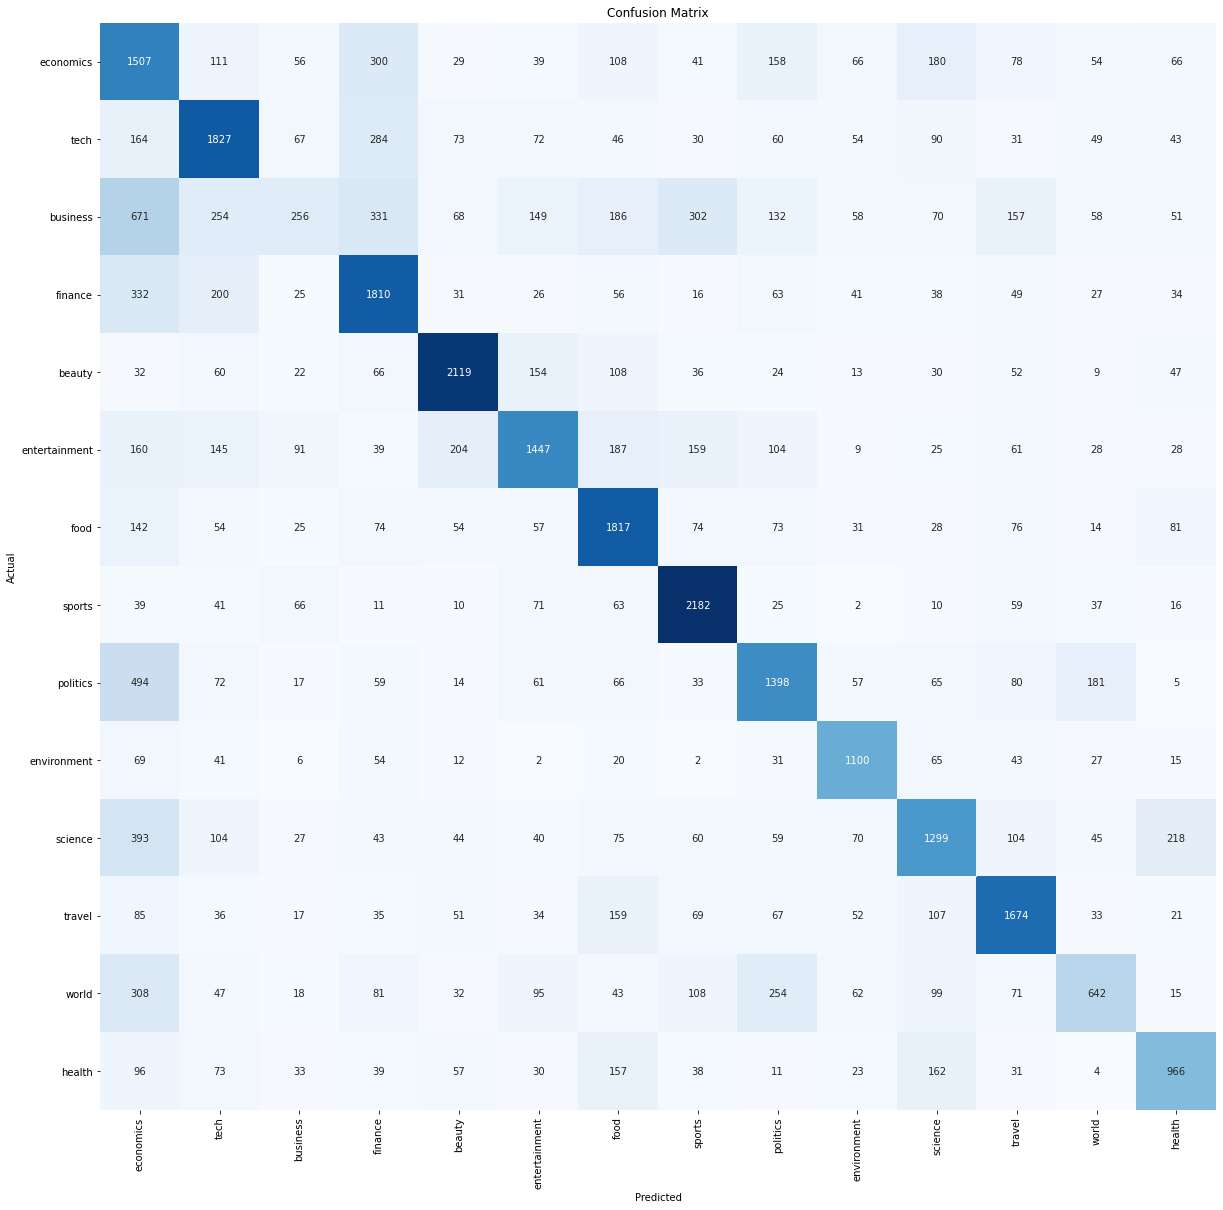

In [45]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(
    y_test, y_pred, target_names=list(mapping.keys()))

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(14) + 0.5,
           labels=list(mapping.keys()), rotation=90)
plt.yticks(ticks=np.arange(14) + 0.5,
           labels=list(mapping.keys()), rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [46]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
                precision    recall  f1-score   support

    economics       0.34      0.54      0.41      2793
         tech       0.60      0.63      0.61      2890
     business       0.35      0.09      0.15      2743
      finance       0.56      0.66      0.61      2748
       beauty       0.76      0.76      0.76      2772
entertainment       0.64      0.54      0.58      2687
         food       0.59      0.70      0.64      2600
       sports       0.69      0.83      0.75      2632
     politics       0.57      0.54      0.55      2602
  environment       0.67      0.74      0.70      1487
      science       0.57      0.50      0.54      2581
       travel       0.65      0.69      0.67      2440
        world       0.53      0.34      0.42      1875
       health       0.60      0.56      0.58      1720

     accuracy                           0.58     34570
    macro avg       0.58      0.58      0.57     34570
 weighted avg   